# BoundingBox and Polygon Annotations on Images

In [1]:
# Set up machine and login information to use in the rest of this notebook
from getpass import getpass

dbinstance = input("Machine name: ")
password = getpass("Password:")

Machine name:  demo.gcp.cloud.aperturedata.io
Password: ········


In [2]:
# Connector class offers a way to connect to an instance of ApertureDB
from aperturedb import Connector

client = Connector.Connector(dbinstance, user="admin", password=password)

In [3]:
# Simple query to see how the database is doing
# https://docs.aperturedata.io/query_language/Reference/db_commands/GetStatus
query = [{
    "GetStatus": {
    }
}]

# Execute the query to get back a JSON response for GetStatus 
response, blobs = client.query(query)

client.print_last_response()

[
    {
        "GetStatus": {
            "info": "OK",
            "status": 0,
            "system": "ApertureDB",
            "version": "0.17.23"
        }
    }
]


## Add an Image of a Dish and Annotate it

**[Regions of interest](https://docs.aperturedata.io/category/image-and-related-commands) like bounding boxes or polygons are _always_ associated with an image. You can add a new image together with these regions or find an existing one and connect it with as many of these regions.**

In [4]:
query = [{
    "AddImage": {
        "_ref": 1,                         # Assign a reference to the result of this query which is this image we are adding
        "properties": {
            "name": "Focaccia",
            "id": 35,
            "contributor": "Vishakha",
            "category": "starter",
            "cuisine": "Italian",
            "location": "Brittany",
            "caption": "fresh made focaccia with herbs from the garden"
        },
        "if_not_found": {                  # avoid adding twice
            "id": ["==", 35]
        }
    }
}, {
    "AddBoundingBox": {
        "image_ref": 1,            # Use the reference attached in the previous command to indicate the source of this bounding box
        "rectangle": {
            "x": 40,                # pixels offset from the left edge
            "y": 1500,              # pixels offset from the top edge
            "width": 2200,          # box width in pixels
            "height": 1800          # box height in pixels
        },
        "label": "Pan",
        "properties": {
            "name": "iron pan",
            "annotation_source": "manual"
        },
        "if_not_found": {         # Only add the bounding box if it doesn't already exist
            # note: These checks will operate faster if properties 'name' and 'annotation_source' are indexed
            "name": ["==", "iron pan"], 
            "annotation_source": ["==", "manual"]
        }
    }
}, {
    "AddPolygon": {
        "image_ref": 1,            # Use the reference attached in the previous command to indicate the source of this bounding box
        "polygons": [
            [
                [483.84,2890.94],
                [416.40,2314.37],
                [704.592,1935.36],
                [1391.04,1854.72],
                [1814.4,2177.28],
                [1844.64,2741.76],
                [1118.88,3104.64]
            ]
        ],
        "label": "Bread",
        "properties": {
            "name": "Homemade Foccacia",
            "annotation_source": "labelstudio"
        },
        "if_not_found": {         # Only add the polygon if it doesn't already exist
            # note: These checks will operate faster if properties 'name' and 'annotation_source' are indexed
            "name": ["==", "Homemade Foccacia"], 
            "annotation_source": ["==", "labelstudio"]
        }
    }
}]

# Read the image data as a binary blob
fd = open("data/focaccia_brittany.jpg", 'rb')
image_arr = [ fd.read() ]
fd.close()

response, blobs = client.query(query, image_arr)

client.print_last_response()

[
    {
        "AddImage": {
            "status": 0
        }
    },
    {
        "AddBoundingBox": {
            "status": 0
        }
    },
    {
        "AddPolygon": {
            "status": 0
        }
    }
]


## Retrieve Pixels in Regions of Interest

[
    {
        "FindImage": {
            "returned": 0,
            "status": 0
        }
    },
    {
        "FindBoundingBox": {
            "blobs_start": 0,
            "entities": [
                {
                    "_area": 3960000,
                    "_blob_index": 0,
                    "_coordinates": {
                        "height": 1800,
                        "width": 2200,
                        "x": 40,
                        "y": 1500
                    },
                    "_label": "Pan",
                    "_uniqueid": "1.894797.223840",
                    "annotation_source": "manual",
                    "name": "iron pan"
                }
            ],
            "returned": 1,
            "status": 0
        }
    },
    {
        "FindPolygon": {
            "blobs_start": 1,
            "entities": [
                {
                    "_area": 1359696,
                    "_blob_index": 1,
                    "_label": "Bread",
         

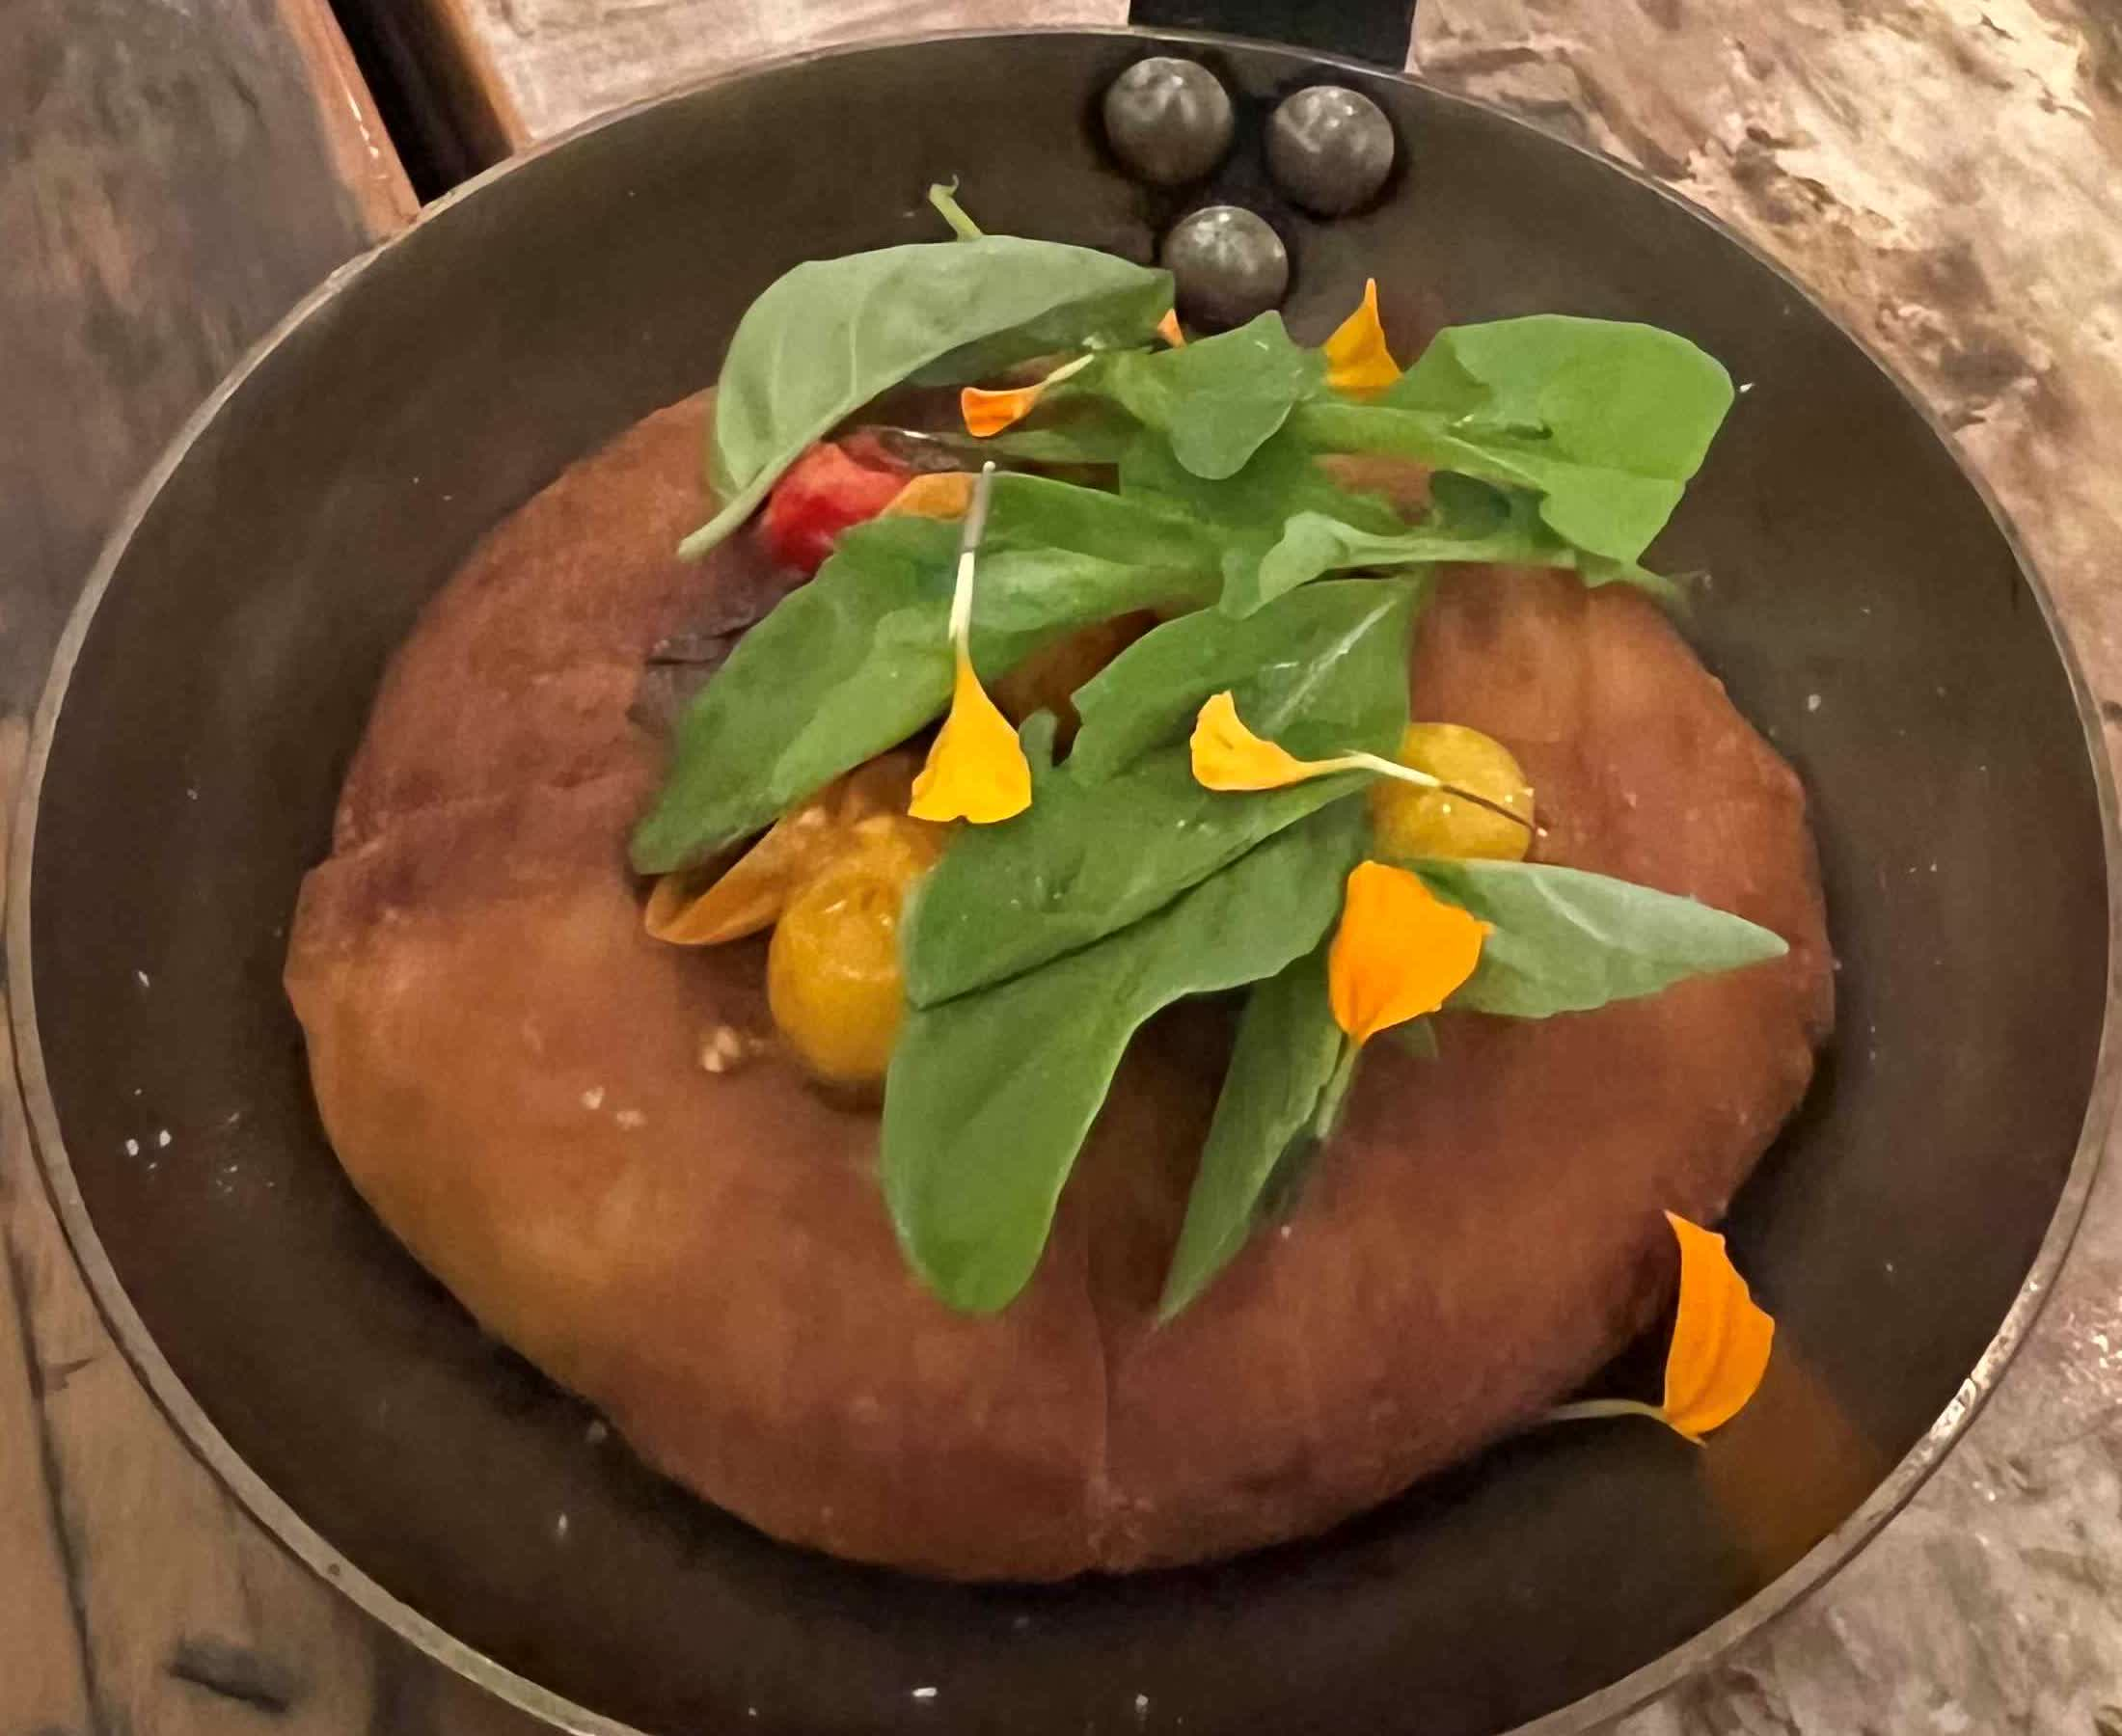

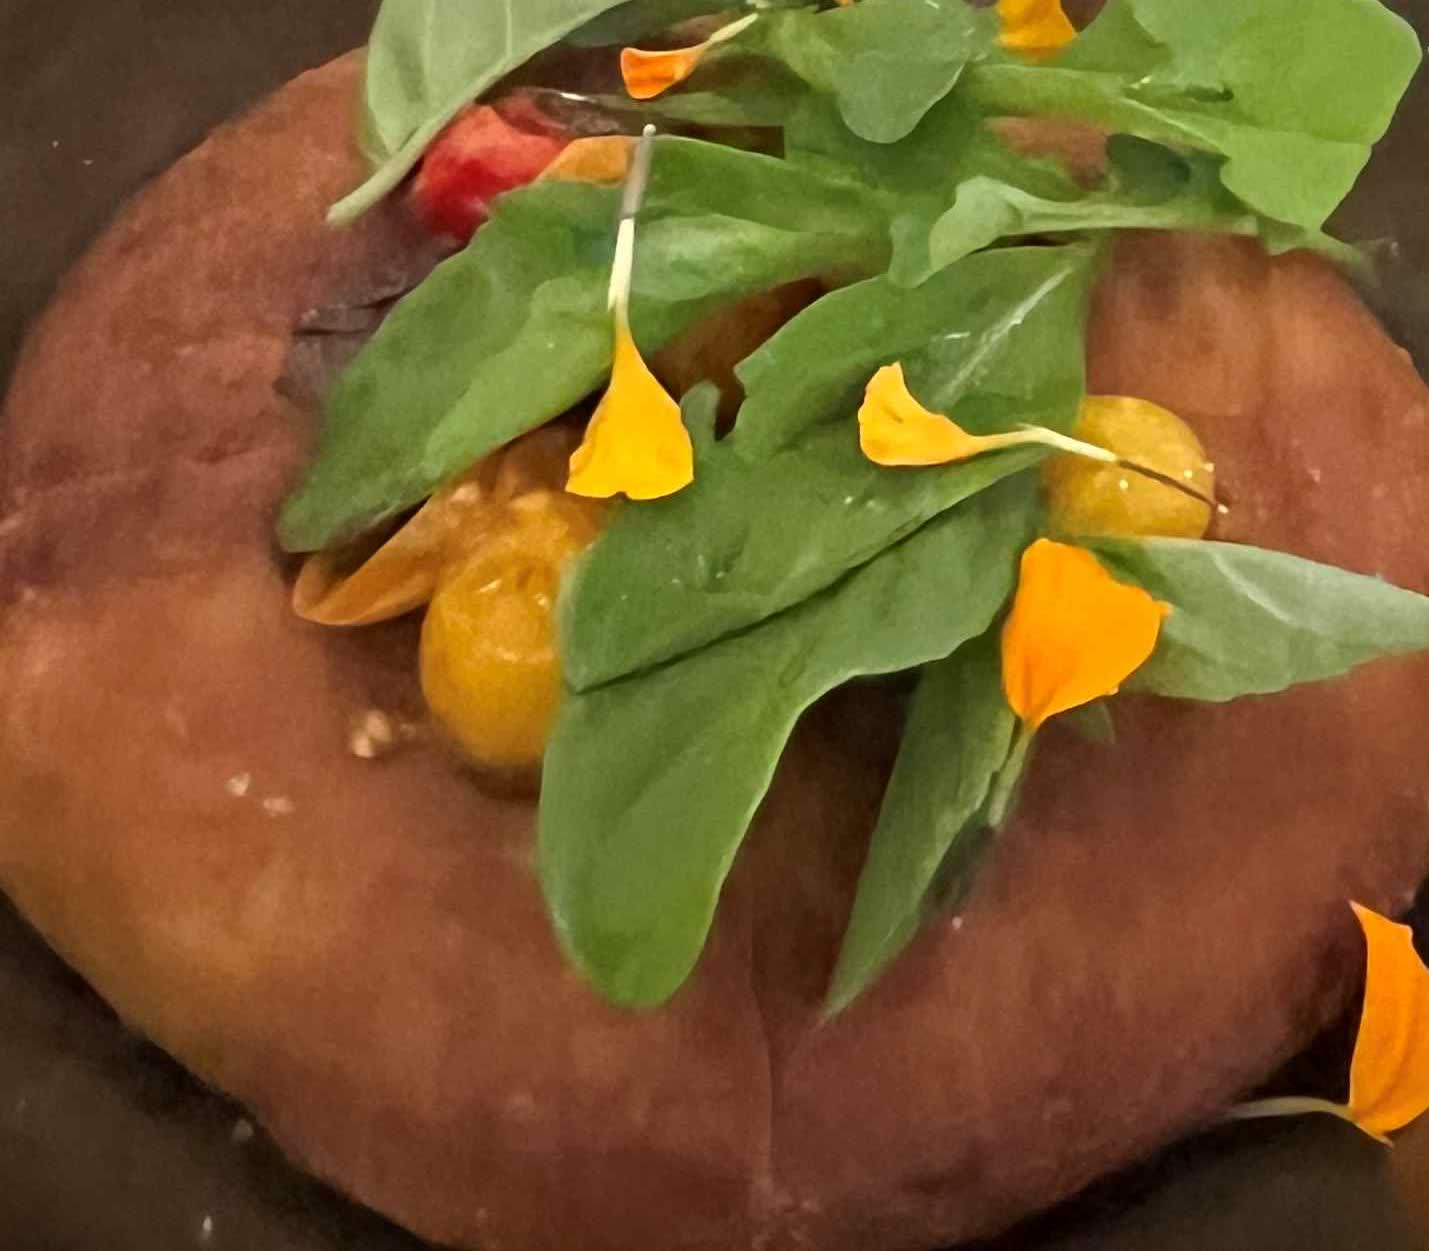

In [5]:
from aperturedb import NotebookHelpers as nh   # Our helper package for image displays and other utilities

query = [ {
    "FindImage": {
        "_ref": 1,
        "constraints": {
            "name": ["==", "Focaccia"],
            "location": [">", "A"] 
        },
        "blobs": False             # Don't retrieve pixel data from the image for this command...
    }
}, {
    "FindBoundingBox": {
        "is_connected_to": {
            "ref": 1
        },
        "with_label": "Pan",
        "results": {
            "all_properties": True
        },
        "coordinates": True,
        "blobs": True              # Instead, retrieve pixel data from the bounding box...
    }
}, {
    "FindPolygon": {
        "is_connected_to": {
            "ref": 1
        },
        "with_label": "Bread",
        "results": {
            "all_properties": True
        },
        "vertices": True,
        "blobs": True              # ... and in this polygon
    }
}
]

res, blobs = client.query(query)
client.print_last_response()

from IPython.display import display,Image
image = Image(blobs[0], format="JPEG")
display(image)
image = Image(blobs[1], format="JPEG")
display(image)

## Find an image by its label

[
    {
        "FindBoundingBox": {
            "entities": [
                {
                    "_coordinates": {
                        "height": 1800,
                        "width": 2200,
                        "x": 40,
                        "y": 1500
                    },
                    "_label": "Pan"
                }
            ],
            "returned": 1,
            "status": 0
        }
    },
    {
        "FindImage": {
            "blobs_start": 0,
            "returned": 1,
            "status": 0
        }
    }
]


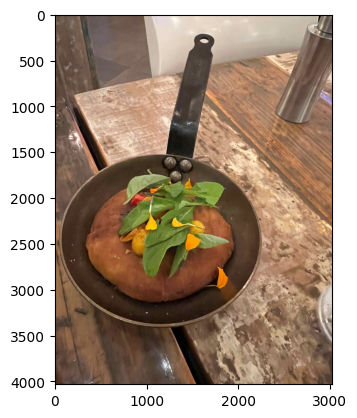

In [6]:
query = [ {
    "FindBoundingBox": {
        "_ref": 1,
        "with_label": "Pan",
        "coordinates": True,
        "labels": True,
        "blobs": False
    }}, {
    "FindImage": {
        "is_connected_to": {
            "ref": 1
        },
        "blobs": True
    }
} ]

res, blobs = client.query(query)

client.print_last_response()
nh.display(blobs)

## Find Polygon pixels by label

[
    {
        "FindPolygon": {
            "entities": [
                {
                    "_area": 1359696,
                    "_bounds": {
                        "height": 1251,
                        "width": 1429,
                        "x": 416,
                        "y": 1854
                    },
                    "_hulls": [
                        [
                            [
                                1391.0400390625,
                                1854.719970703125
                            ],
                            [
                                1814.4000244140625,
                                2177.280029296875
                            ],
                            [
                                1844.6400146484375,
                                2741.760009765625
                            ],
                            [
                                1118.8800048828125,
                                3104.639892578125
      

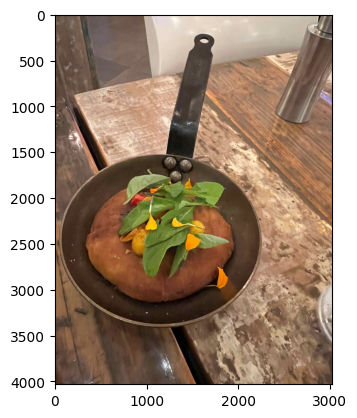

In [7]:
query = [ {
    "FindPolygon": {
        "_ref": 1,
        "with_label": "Bread",
        "vertices": True,
        "areas": True,
        "hulls": True,
        "bounds": True,
        "labels": True,
        "blobs": False
    }}, {
    "FindImage": {
        "is_connected_to": {
            "ref": 1
        },
        "blobs": True
    }
} ]

res, blobs = client.query(query)

client.print_last_response()
nh.display(blobs)

## Compute IoU

**You can use the in-built [RegionIoU](https://docs.aperturedata.io/query_language/Reference/image_commands/region_ops/RegionIoU) command to find how much two regions of interest overlap**

In [8]:
query = [ {
    "FindBoundingBox": {
        "_ref": 1,
        "with_label": "Pan",
        "coordinates": True,
        "labels": True,
        "blobs": False
    }
},{
    "FindPolygon": {
        "_ref": 2,
        "with_label": "Bread",
        "bounds": True,
        "labels": True,
        "blobs": False
    }
},{
    "RegionIoU": {
        "roi_1": 1,
        "roi_2": 2
    }
}]

res, blobs = client.query(query)

client.print_last_response()

[
    {
        "FindBoundingBox": {
            "entities": [
                {
                    "_coordinates": {
                        "height": 1800,
                        "width": 2200,
                        "x": 40,
                        "y": 1500
                    },
                    "_label": "Pan"
                }
            ],
            "returned": 1,
            "status": 0
        }
    },
    {
        "FindPolygon": {
            "entities": [
                {
                    "_bounds": {
                        "height": 1251,
                        "width": 1429,
                        "x": 416,
                        "y": 1854
                    },
                    "_label": "Bread"
                }
            ],
            "returned": 1,
            "status": 0
        }
    },
    {
        "RegionIoU": {
            "IoU": [
                [
                    0.34335757575757575
                ]
            ],
            "stat

## Delete the regions of interest and cleanup. 

In [9]:
query = [ {
    "DeleteBoundingBox": {               # To delete by label, do a Find with a ref and then delete using the ref
        "constraints": {
            "annotation_source": ["==", "manual"]
        }
    }
},{
    "DeletePolygon": {
        "constraints": {
            "annotation_source": ["==", "labelstudio"]
        }
    }
},{
    "DeleteImage": {
        "constraints": {
            "name": ["==", "Focaccia"]
        }
    }
}]

res, blobs = client.query(query)

client.print_last_response()

[
    {
        "DeleteBoundingBox": {
            "count": 1,
            "status": 0
        }
    },
    {
        "DeletePolygon": {
            "count": 1,
            "status": 0
        }
    },
    {
        "DeleteImage": {
            "count": 1,
            "status": 0
        }
    }
]
